# # 自行計算 Shapley value
### [How to calculate shapley values from scratch](https://www.depends-on-the-definition.com/shapley-values-from-scratch/)

## 載入套件

In [1]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import datasets

## 載入資料

In [2]:
X, y = datasets.load_breast_cancer(return_X_y=True, as_frame=True)

## 資料分割

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 模型訓練

In [4]:
clf = make_pipeline(StandardScaler(), LogisticRegression())
clf.fit(X_train.values, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

## 自行計算第16個特徵的Shapley value

In [5]:
x = X_test.iloc[0] # 第一筆測試資料
j = 15   # 第16個特徵
M = 1000 # 測試 1000 次
n_features = len(x)
marginal_contributions = []
feature_idxs = list(range(n_features))
feature_idxs.remove(j)
for _ in range(M):
    # 抽樣訓練資料一筆資料
    z = X_train.sample(1).values[0]
    # 所有組合
    x_idx = random.sample(feature_idxs, min(max(int(0.2*n_features), 
                            random.choice(feature_idxs)), int(0.8*n_features)))
    z_idx = [idx for idx in feature_idxs if idx not in x_idx]
    
    # 含第16個特徵的X，在組合內以測試資料填入，不在組合內以訓練資料填入
    x_plus_j = np.array([x[i] if i in x_idx + [j] else z[i] for i in range(n_features)])
    # 不含第16個特徵的X
    x_minus_j = np.array([z[i] if i in z_idx + [j] else x[i] for i in range(n_features)])
    
    # 計算邊際貢獻(marginal contribution)
    marginal_contribution = clf.predict_proba(x_plus_j.reshape(1, -1))[0][1] - \
            clf.predict_proba(x_minus_j.reshape(1, -1))[0][1]
    marginal_contributions.append(marginal_contribution)
    
# 計算邊際貢獻平均值    
phi_j_x = sum(marginal_contributions) / len(marginal_contributions)  
print(f"Shaply value for feature {j}: {phi_j_x:.5}")

Shaply value for feature 15: 0.010254


In [6]:
X.columns[j]

'compactness error'

## 以 SHAP 套件驗證

In [7]:
import shap

explainer = shap.KernelExplainer(clf.predict_proba, X_train.values)
shap_values = explainer.shap_values(x)
print(f"Shaply value calulated from shap: {shap_values[1][j]:.5}")

Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Shaply value calulated from shap: 0.01366


# 範例2. 自行計算 Shapley value 
### [Computing SHAP values from scratch](https://afiodorov.github.io/2019/05/20/shap-values-explained/)

## 載入套件

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree

## 載入資料

In [17]:
with open('./data/housing.data', encoding='utf8') as f:
    data = f.readlines()
all_fields = []
for line in data:
    line2 = line[1:].replace('   ', ' ').replace('  ', ' ')
    fields = []
    for item in line2.split(' '):
        fields.append(float(item.strip()))
        if len(fields) == 14:
            all_fields.append(fields)
df = pd.DataFrame(all_fields)
df.columns = 'CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV'.split(',')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 模型訓練

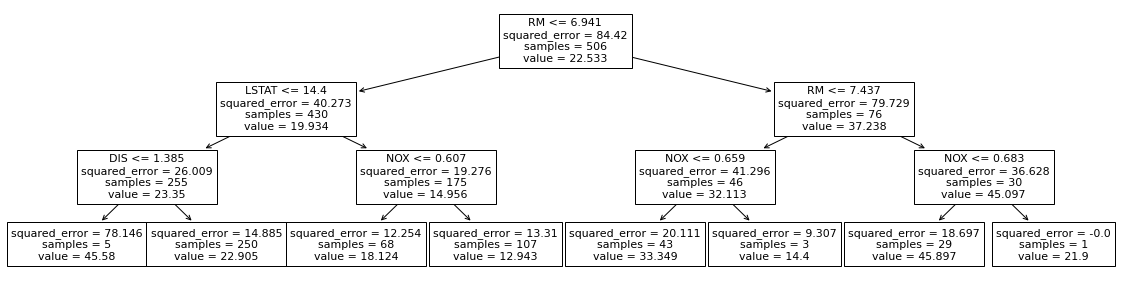

In [18]:
y = df['MEDV']
df = df[['RM', 'LSTAT', 'DIS', 'NOX']]

clf = DecisionTreeRegressor(max_depth=3)
clf.fit(df, y)
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
_ = plot_tree(clf, ax=ax, feature_names=df.columns)

## 以 SHAP 套件計算 Shapley value

In [6]:
import shap
import tabulate

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(df[:1]) # 第一筆資料
print(tabulate.tabulate(pd.DataFrame(
    {'shap_value': shap_values.squeeze(),
     'feature_value': df[:1].values.squeeze()}, index=df.columns),
                        tablefmt="github", headers="keys"))

|       |   shap_value |   feature_value |
|-------|--------------|-----------------|
| RM    |    -2.3953   |           6.575 |
| LSTAT |     2.46131  |           4.98  |
| DIS   |    -0.329802 |           4.09  |
| NOX   |     0.636187 |           0.538 |


## Shapley value + Y平均數 = 預測值

In [12]:
shap_values.sum() + y.mean(), clf.predict(df[:1])[0]

(22.905200000000004, 22.9052)

## 自行計算 Shapley value

In [14]:
from itertools import combinations
import scipy

# 計算特定組合的邊際貢獻
def pred_tree(clf, coalition, row, node=0):
    left_node = clf.tree_.children_left[node]
    right_node = clf.tree_.children_right[node]
    is_leaf = left_node == right_node

    if is_leaf:
        return clf.tree_.value[node].squeeze()

    feature = row.index[clf.tree_.feature[node]]
    if feature in coalition:
        if row.loc[feature] <= clf.tree_.threshold[node]:
            # go left
            return pred_tree(clf, coalition, row, node=left_node)
        else: # go right
            return pred_tree(clf, coalition, row, node=right_node)

    # take weighted average of left and right
    wl = clf.tree_.n_node_samples[left_node] / clf.tree_.n_node_samples[node]
    wr = clf.tree_.n_node_samples[right_node] / clf.tree_.n_node_samples[node]
    value = wl * pred_tree(clf, coalition, row, node=left_node)
    value += wr * pred_tree(clf, coalition, row, node=right_node)
    return value

# 計算特定組合的平均邊際貢獻
def make_value_function(clf, row, col):
    def value(c):
        marginal_gain = pred_tree(clf, c + [col], row) - pred_tree(clf, c, row)
        num_coalitions = scipy.special.comb(len(row) - 1, len(c))
        return marginal_gain / num_coalitions
    return value

# 各種組合
def make_coalitions(row, col):
    rest = [x for x in row.index if x != col]
    for i in range(len(rest) + 1):
        for x in combinations(rest, i):
            yield list(x)

# 計算 Shapley value
def compute_shap(clf, row, col):
    v = make_value_function(clf, row, col)
    return sum([v(coal) / len(row) for coal in make_coalitions(row, col)])

# 顯示 Shapley value
print(tabulate.tabulate(pd.DataFrame(
    {'shap_value': shap_values.squeeze(),
     'my_shap': [compute_shap(clf, df[:1].T.squeeze(), x) for x in df.columns],
     'feature_value': df[:1].values.squeeze()
    }, index=df.columns), tablefmt="github", headers="keys"))

|       |   shap_value |   my_shap |   feature_value |
|-------|--------------|-----------|-----------------|
| RM    |    -2.3953   | -2.3953   |           6.575 |
| LSTAT |     2.46131  |  2.46131  |           4.98  |
| DIS   |    -0.329802 | -0.329802 |           4.09  |
| NOX   |     0.636187 |  0.636187 |           0.538 |
